In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

import convis
v = 10.0
the_input = np.concatenate([contrast * convis.samples.moving_bars(t=200, vt=20, vx=v*np.sin(phi), vy=v*np.cos(phi)) 
                            for phi in np.linspace(0,360.0,30.0) for contrast in [0.0,1.0]], axis = 0)


Using gpu device 0: Quadro K620 (CNMeM is disabled, cuDNN not available)


## An orientation selective LN model

This example creates a visual model with a two-dimensional receptive field which has the shape of a gabor patch.
To discard anti-phase responses which would anihilate the mean response to the stimulus, the output is half-wave rectified and also squared to amphasize strong responses.

Note that the non-linearity is not defined as its own layer here, but as a manipulation of the output of the previous layer (`rf.graph`).

In [2]:
rf = convis.filters.simple.ConvolutionFilter2d({'kernel': convis.samples.gabor_kernel(phi=0.0) },name='ReceptiveField')

nonlinearity = lambda x: x.clip(0,1000)**2 # theano tensors support many operations of numpy arrays

m = convis.make_model(nonlinearity(rf.graph))

In [5]:
v = 10.0
the_input = np.concatenate([contrast * convis.samples.moving_bars(t=200, vt=20, vx=v*np.sin(phi), vy=v*np.cos(phi)) 
                            for phi in np.linspace(0,360.0,30.0) for contrast in [0.0,1.0]], axis = 0)
import litus
litus.animate(the_input[::25]) # very sped up video

100%|██████████| 480/480 [00:33<00:00, 15.00it/s]


In [15]:
%time o = m.run(the_input)

CPU times: user 951 ms, sys: 43.1 ms, total: 994 ms
Wall time: 992 ms


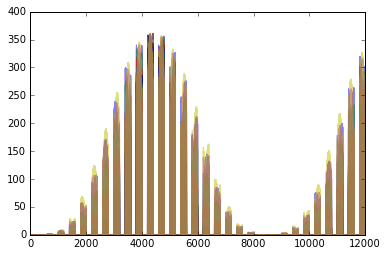

In [16]:
plt.plot(o[0][:,10,:],alpha=0.5)

## Defining a new Layer

To define a new layer, a few points have to be observed:

 1. the layer should inherit from the `convis.base.N` (or `convis.N`) class
 2. the layer should contain a `default_input` which is a sum of 3d or 5d tensors, so that inputs can be added to the layer
     * you can create such an input by invoking `self.create_input()` in your constructor
     * or call `self.create_input("some_name")` to create named inputs if you want to expose more than one
 3. supply the `graph` ie. the overall output of your layer to the super constructor:
     * if you have more than one output, put them in a list
     * Replace 'NameOfYourClass' with the name of your class in the expression: `super(NameOfYourClass, self).__init__(graph, ...)`
 4. (optional) think about which configuration options you want to expose
     * if you do not need any configuration, set `self.expects_config` to False
     * if you want to initialize a parameter from the configuration, follow the example of 'b' in the code
 
 

Parameter updated without function
Parameter updated without function


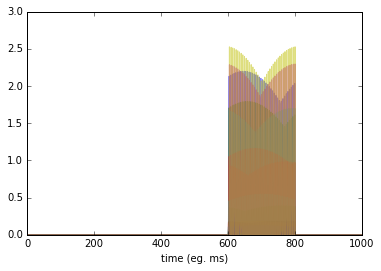

In [34]:
rf = convis.filters.simple.ConvolutionFilter2d({'kernel': convis.samples.gabor_kernel(phi=0.0) },name='ReceptiveField')

class Nonlinearity(convis.N):
    def __init__(self,name='NonLinearity',**kwargs):
        a = convis.shared_parameter(0.0, name='a')
        b = convis.shared_parameter(1.0, name='b', config_key='b')
        graph = a + b * self.create_input().clip(0,1000)
        super(Nonlinearity, self).__init__(graph,name=name,**kwargs)

nonlinearity = Nonlinearity(config={'b':2.0})
temporalfilter = convis.ConvolutionFilter1d({'kernel': convis.numerical_filters.exponential_filter_1d(tau=0.01)}, name='E')
convis.connect([rf,temporalfilter, nonlinearity])
m = convis.make_model(nonlinearity)
o = m.run(the_input)
plt.plot(o[0][:1000,10,:],alpha=0.5)
plt.xlabel('time (eg. ms)')

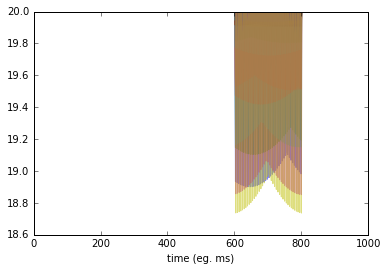

In [35]:
m.parameters.NonLinearity.a = 20.0
m.parameters.NonLinearity.b = -1.0
o = m.run(the_input)
plt.plot(o[0][:1000,10,:],alpha=0.5)
plt.xlabel('time (eg. ms)')

## Connecting Layers

Layers can either be connected one by one by using `add_input` or in batch by using `convis.connect`.
A shorthand for `b.addinput(a)` is `b += a`.
The following is equivalent:

    convis.connect([a,b,c])

    c.add_input(b)
    b.add_input(a)

    c += b # if c and b are convis Layers
    b += a
    
Both will result in a graph in which only `a` has an open input. `b` recieves the output of `a` as input, `c` recieves the output of b.

If more than one input or output are specified, a specific one can be set like this:

    b.add_output(a.graph[0],'input_0') 
    # connects the first element of the output of a to the input named 'input_0' of b
    b.add_output(a.graph[1],'input_1')
    b.add_output(a.graph[2],'input_2')

If two outputs are connected to the same input, their values will be added together.

More complciated connectivity can be achieved in `convis.connect` by nesting lists:

    convis.connect([a,[b,c,[d,e,f]],g])
    
    # is equivalent to:
    b.add_input(a) # the second nested level is even, so connected in parallel
    c.add_input(a)
    d.add_input(a)
    e.add_input(d) # the third nested level is odd, so again connected in sequence
    f.add_input(e) 
    g.add_input(b) # after a parallel nesting is closed, the inputs are all summed in the next layer
    g.add_input(c)
    g.add_input(f)
    


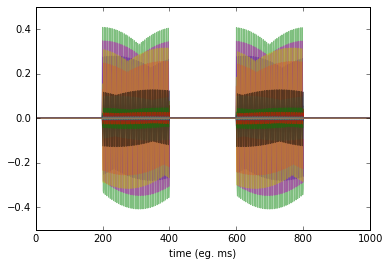

In [42]:
receptors = convis.filters.simple.ConvolutionFilter2d(
    {'kernel': convis.numerical_filters.gauss_filter_2d(2.0,2.0) },
    name='ReceptorLayer')
horizontal_cells = convis.filters.simple.ConvolutionFilter2d(
    {'kernel': convis.numerical_filters.gauss_filter_2d(4.0,4.0) },
    name='HorizontalLayer')
rf = convis.RF_2d_kernel_filter(
    {'kernel': convis.samples.gabor_kernel(size=the_input.shape[1]) },
    name='ReceptiveField')

horizontal_cells += receptors
rf += receptors
rf += -0.5*horizontal_cells.graph

m = convis.make_model(rf)
o = m.run(the_input)
plt.plot(o[0][:1000,10,:],alpha=0.5)
plt.xlabel('time (eg. ms)')

In [43]:
print m.draw_simple_diagram()

input -> ReceptorLayer -> HorizontalLayer -> output
                       -> ReceptiveField -> output



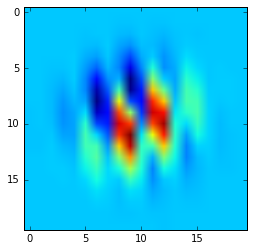

In [37]:
plt.imshow(o[0][340,:,:])

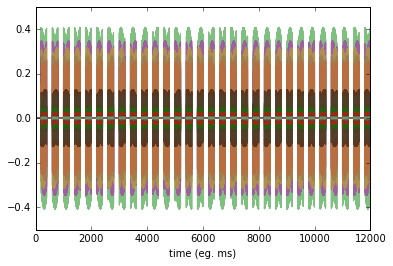

In [38]:
plt.plot(o[0][:,10,:],alpha=0.5)
plt.xlabel('time (eg. ms)')

In [19]:
import litus
litus.animate(o[0][:10000:10])

100%|██████████| 1000/1000 [01:10<00:00, 15.95it/s]


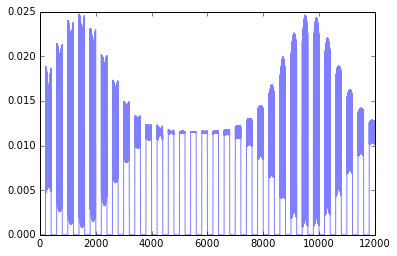

In [39]:
plt.plot(o[0][:,:,:].clip(0,None).mean((1,2)),alpha=0.5)

In [24]:
convis.describe(o[0].clip(0,None))

{}

In [ ]:
convis.numerical_filters.exponential_filter_5d()